Информация по профилям для тех кто их имеет вполне себе подгружается, но просто не отображается. В этом случае у нас появляется необходимость в более детальном управлении отображением данных и тут на сцену выходит очень полезная библиотека Pydantic, которую мы установили в прошлый раз.

Благодаря этой библиотеке мы можем описать так называемую модель отображения данных, которую можно будет максимально удобно использовать в своих приложениях.

Перед тем как мы ее напишем хочу обратить внимание на важный момент. Мы на уровне моделей таблиц указали необходимость подгрузки автоматическую со связанной таблицы профилей. То есть, для постов и комментариев эта схема работать не будет и нам необходимо будет данные подгружать отдельно. Если сейчас я уберу из модели User строку lazy="joined", то получу следующую ошибку:

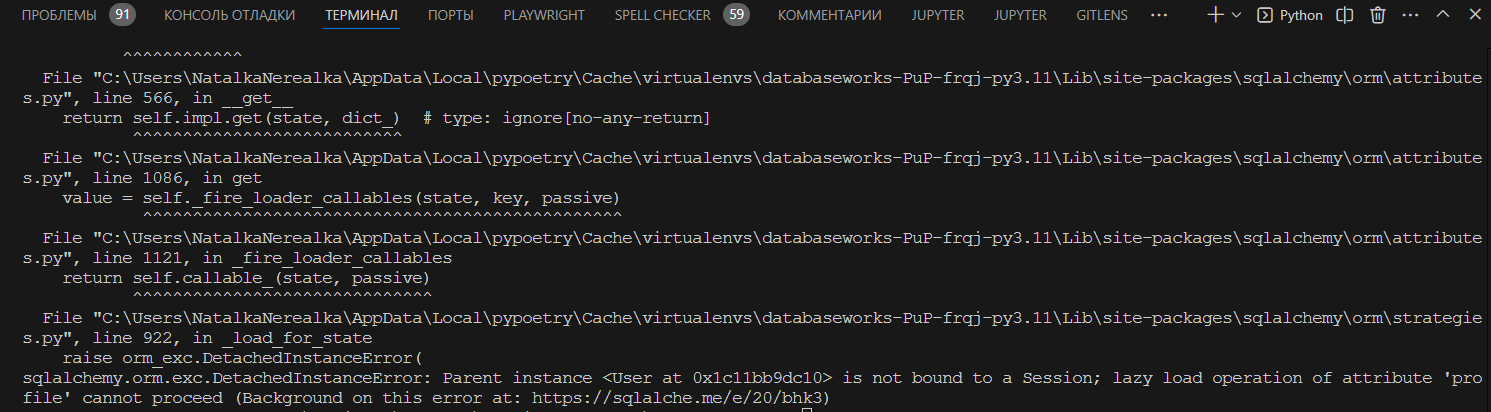

Ошибка sqlalchemy.orm.exc.DetachedInstanceError говорит о том, что объект модели, с которым мы работаем (в данном случае User), был отсоединен от сессии, и SQLAlchemy не может выполнить ленивую загрузку (lazy loading) связанного объекта profile, что логично, ведь этот объект не загружен.

Опишем простую Pydantic модель. Там мы просто обозначим какие данные и в каком виде мы хотим получить.

Для удобства отдельно опишем модель для профиля (те данные, которые нас интересуют для просмотра) и модель users.

создам файл schemas.py.

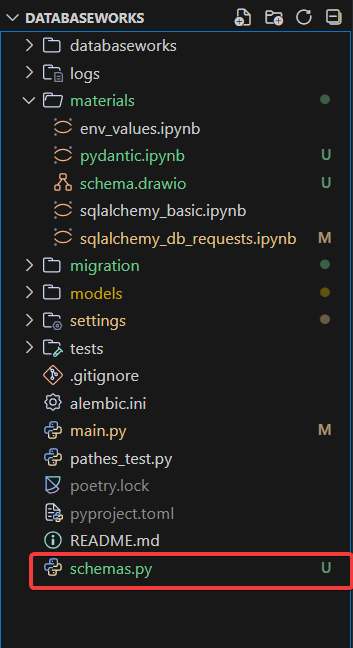

Теперь опишем первую модель (схему), которая будет описывать полученные данные с таблицы profiles.

In [ ]:
from typing import List
from pydantic import BaseModel, ConfigDict

from models.enums import GenderEnum, ProfessionEnum


class ProfilePydantic(BaseModel):
    name: str
    surname: str
    age: int
    gender: GenderEnum
    profession: ProfessionEnum
    interests: List[str]|None
    contacts: dict|None
    
    model_config = ConfigDict(from_attributes=True, use_enum_values=True)

Синтаксис чем-то похож на современное описание моделей таблиц в ORM SQLAlchemy, разве что тут нет Mapped и mapped_column.

Мы создаем Pydantic модель для того, чтобы валидировать и структурировать входящие данные в соответствии с заданными типами. Pydantic позволяет легко описывать схему данных и выполнять автоматическую проверку типов, а также трансформировать значения в нужный формат при необходимости (наш случай).

Описания полей достаточно понятны, а что заслуживает внимание так это model_config

Разберемся с атрибутами и значениями.

- from_attributes = True: это позволяет модели автоматически маппить атрибуты Python объектов на поля модели. Примерно то что мы делали в методе to_dict, но более расширенно.

- use_enum_values = True: это указание преобразовывать значения перечислений в их фактические значения, а не в объекты перечислений. Просто для удобства восприятия человеком.

Теперь опишем схему с пользователями.

In [ ]:
class UserPydantic(BaseModel):
    username: str
    email: str
    profile: ProfilePydantic | None

    model_config = ConfigDict(from_attributes=True, use_enum_values=True)

Из нового синтаксиса тут только то что мы добавили поле profile и в качестве описания этого поля добавили схему, описанную выше

Использованиие pydantic при выводе строк данных из БД

In [ ]:
from models.user import User


all_users = User.get_all()
for user in all_users:
    user_pydantic = UserPydantic.model_validate(user)
    print(user_pydantic)
    print(dict(user_pydantic))

А вот теперь мы получили то, что действительно хотели. С такой вложенной структурой максимально удобно работать каждому, кто знаком с базовым Python синтаксисом.

# Получение конкретных значений из нужных колонок

На данном этапе мы просто отсекли ненужные колонки, такие как update_at и createt_at в двух таблицах, но это не значит, что мы их не получили.

Чтобы извлекать только отдельные значения из колонок, например, username и id пользователя, необходимо использовать другие подходы при выполнении запросов. Методы scalar и scalars здесь не подходят, так как они возвращают либо одно значение, либо список значений одной колонки или модели, что ограничивает их применение для более сложных запросов с выборкой нескольких полей.

В таких случаях стоит использовать методы, которые позволяют получить именно те колонки, которые вас интересуют, и работать с ними напрямую.

Давайте опишем ситуацию, когда мы хотим получить значение user_name и id всех пользователей с таблицы users (модель User) и, для того чтоб вы увидели запрос мы отобразим его в консоли.



определим метод для подбора конкретных данных и БД в модели User

In [ ]:
@classmethod
@connection
def get_all_username_id(cls, session: Session = None):
    rows = session.execute(select(cls.id, cls.username))
    users = rows.all()
    return users

Определяем Pydantic модель для описанного выше метода

In [ ]:
class UsernameIdPydantic(BaseModel):
    id: int
    username: str

    model_config = ConfigDict(from_attributes=True)

Проверяем выполнение

In [ ]:
all_usernames_ids = User.get_all_username_id()

for i in all_usernames_ids:
    # print(i)
    # data = {'user_id': i[0], 'username': i[1]} 
    # print(data)
    rez = UsernameIdPydantic.model_validate(i)
    print(dict(rez))